# Tutorial 6: Time Series

In this tutorial, we will perform the avatarization of data that contains time series. The approach presented here can be used to anonymize time series that contain a small number of data points.

## Connection

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os

url = os.environ.get("AVATAR_BASE_URL")
username = os.environ.get("AVATAR_USERNAME")
password = os.environ.get("AVATAR_PASSWORD")

In [3]:
# This is the client that you'll be using for all of your requests
from avatars.client import ApiClient
from avatars.models import (
    AvatarizationJobCreate,
    AvatarizationParameters,
    ImputationParameters,
    ImputeMethod,
    ExcludeCategoricalParameters,
    ExcludeCategoricalMethod,
    RareCategoricalMethod,
)
from avatars.models import ReportCreate

from avatars.api import AvatarizationPipelineCreate
from avatars.processors import ProportionProcessor
from avatars.processors import GroupModalitiesProcessor
from avatars.processors import RelativeDifferenceProcessor
from avatars.processors import PerturbationProcessor
from avatars.processors import ExpectedMeanProcessor

# The following are not necessary to run avatar but are used in this tutorial
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# Change this to your actual server endpoint, e.g. base_url="https://avatar.company.com"
client = ApiClient(base_url=url)
client.authenticate(username=username, password=password)

# Verify that we can connect to the API server
client.health.get_health()

{'message': 'ok'}

## Load some time series data

We will use an example dataset that contains data on 2 sensors for 50 devices. For each device, 100 time points are available.

In [4]:
df = pd.read_csv("../fixtures/sensors.csv")

In [5]:
df

,id,t,sensor1,sensor2,model
0,0,0,-0.179379,-0.986297,b
1,0,1,1.174766,2.309345,b
2,0,2,0.972917,-0.360927,b
3,0,3,-1.725418,0.806874,b
4,0,4,0.644000,0.394776,b
...,...,...,...,...,...
4995,49,95,-0.216251,-1.164292,a
4996,49,96,0.786436,0.571124,a
4997,49,97,-1.368252,0.358143,a
4998,49,98,1.285907,-2.068543,a


In [6]:
df.to_csv("../fixtures/sensors.csv", index=False)

<Axes: xlabel='t', ylabel='sensor1'>

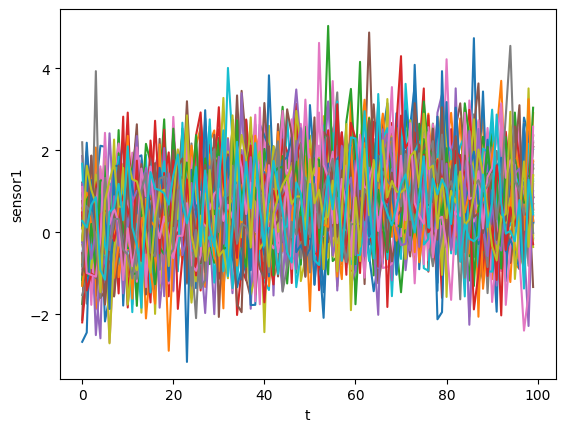

In [7]:
sns.lineplot(
    df, x="t", y="sensor1", hue="id", palette=sns.color_palette(), legend=False
)

<Axes: xlabel='t', ylabel='sensor2'>

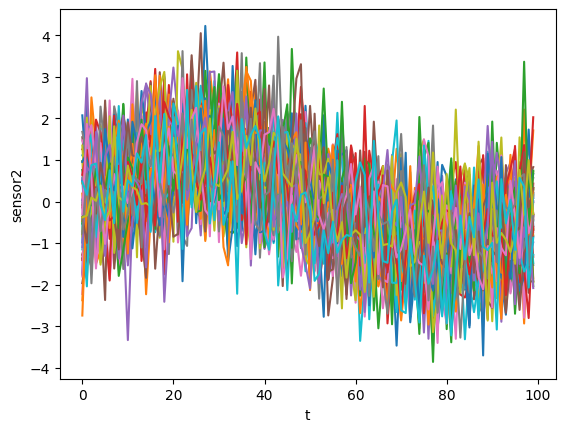

In [8]:
sns.lineplot(
    df, x="t", y="sensor2", hue="id", palette=sns.color_palette(), legend=False
)

## Prepare data for avatarization

The avatarization takes as input tabular data where each row contains the data relative to an individual. In the present example, each row should ideally refer to a device.

The number of time points to include in the avatarization can also have an impact and it is currently recommended to use a small number of data points (~ 5 to 10 points) to prevent cases where the data has more variables than individuals. 

To perform the transformation which consists in pivotting the table and sampling a given number of time points, we will use a processor.

We can call this processor `SimpleTimeSeriesProcessor`.

In [9]:
class SimpleTimeSeriesProcessor:
    def __init__(
        self,
        n_points: int,
        id_variable: str,
        time_variable: str,
        values_variables: List[str],
    ):
        self.n_points = n_points
        self.id_variable = id_variable
        self.time_variable = time_variable
        self.values_variables = values_variables
        self.fixed_variables = None
        self.times = None

    def get_sampled_data_for_id(self, df, the_id, to_convert):
        df_individual = df[df[self.id_variable] == the_id]

        idx = np.round(np.linspace(0, len(df_individual) - 1, self.n_points)).astype(
            int
        )  # indices to sample
        df_sampled = df_individual.iloc[idx].reset_index(drop=True)  # sampling

        data = {self.id_variable: [the_id]}

        # Create one variable per pair {variable to convert - time step sampled}
        for c in to_convert:
            for i in df_sampled.index:
                data[c + "_" + str(i)] = [df_sampled.loc[i, c]]

        # For fixed variables, only create one variable and take the first value
        for c in self.fixed_variables:
            data[c] = [df_sampled.loc[0, c]]

        return data

    def preprocess(self, df: pd.DataFrame) -> pd.DataFrame:
        dfs = []  # list of df, one per ID
        to_convert = self.values_variables.copy()
        to_convert.append(self.time_variable)
        self.fixed_variables = [
            c for c in df.columns if c not in to_convert and c != self.id_variable
        ]

        # For each ID, sample points evenly spaced
        for the_id in np.unique(df[self.id_variable]):
            data = self.get_sampled_data_for_id(df, the_id, to_convert)
            dfs.append(pd.DataFrame(data))

        working = pd.concat(dfs)
        working = working.reset_index(drop=True)

        # Save time columns (constant across all individuals) and remove them from preprocessed df
        time_columns = [self.time_variable + "_" + str(i) for i in range(self.n_points)]
        self.times = working[time_columns]
        working = working.drop(columns=time_columns)
        working = working.drop(columns=[self.id_variable])

        return working

    def postprocess(self, source: pd.DataFrame, dest: pd.DataFrame) -> pd.DataFrame:
        working = dest.copy()

        # Add back the saved time information
        working = pd.concat([working, self.times], axis=1)

        # Transform time series variables
        data = {}
        for variable in self.values_variables:
            data[variable] = []
            for the_id in range(len(working)):
                for i in range(self.n_points):
                    data[variable].append(working.loc[the_id, variable + "_" + str(i)])

        # Transform time and ID variables
        data[self.time_variable] = []
        data[self.id_variable] = []
        for the_id in range(len(working)):
            for i in range(self.n_points):
                data[self.time_variable].append(
                    working.loc[the_id, self.time_variable + "_" + str(i)]
                )
                data[self.id_variable].append(the_id)

        # Transform fixed variables
        for c in self.fixed_variables:
            data[c] = []
            for the_id in range(len(working)):
                data[c].extend([working.loc[the_id, c] for _ in range(self.n_points)])

        postprocessed = pd.DataFrame(data)
        return postprocessed[df.columns]

We can check that the behavior of the processor is as expected: after preprocessing, we should have *n_points* variables for each sensor and the static variables (i.e. the *model* variable)

In [10]:
timeseries_processor = SimpleTimeSeriesProcessor(
    n_points=10,
    id_variable="id",
    time_variable="t",
    values_variables=["sensor1", "sensor2"],
)

In [11]:
preprocessed_df = timeseries_processor.preprocess(df)

In [12]:
preprocessed_df.head()

,sensor1_0,sensor1_1,sensor1_2,sensor1_3,sensor1_4,sensor1_5,sensor1_6,sensor1_7,sensor1_8,sensor1_9,...,sensor2_1,sensor2_2,sensor2_3,sensor2_4,sensor2_5,sensor2_6,sensor2_7,sensor2_8,sensor2_9,model
0,-0.179379,0.375243,0.529099,0.683006,0.938851,-0.021375,2.392174,0.939088,1.520509,0.261464,...,1.255355,1.094732,-0.262576,-0.223822,-1.065324,-1.727240,-0.936735,-1.288405,-0.321321,b
1,0.337382,1.678212,1.760756,1.477409,1.714756,0.823183,0.679103,0.906552,3.100120,0.610243,...,-0.623008,1.328806,0.111606,-0.137828,1.369461,-0.822072,-0.127058,-1.399019,-0.657506,c
2,-1.742852,0.060506,2.190076,0.314940,3.059786,2.211505,-0.296958,1.705379,-0.566535,2.342286,...,0.657975,0.680971,-0.756125,0.316926,-0.550118,-1.678126,-0.553883,-0.251373,-1.910796,a
3,0.405151,-0.476680,0.438661,1.803456,1.705575,1.329286,1.566873,1.548528,1.227959,0.861318,...,0.572138,-0.921825,-0.374206,0.208070,1.170391,-0.677840,-2.548593,-0.866792,-1.328033,b
4,0.588244,1.619884,0.459985,-1.481281,-0.061158,2.489173,1.462871,0.681855,2.194679,2.085392,...,-0.300750,0.338266,1.293454,0.914118,0.433547,-0.910596,-0.634898,-0.404068,-0.700592,b


The post-processing step should reformat the data from the pre-processed form into the original one.

In [13]:
postprocessed_df = timeseries_processor.postprocess(df, preprocessed_df)
postprocessed_df.head()

,id,t,sensor1,sensor2,model
0,0,0,-0.179379,-0.986297,b
1,0,11,0.375243,1.255355,b
2,0,22,0.529099,1.094732,b
3,0,33,0.683006,-0.262576,b
4,0,44,0.938851,-0.223822,b


## Avatarization

The data is now in a classic tabular format and can be avatarized.

In [14]:
dataset = client.pandas_integration.upload_dataframe(preprocessed_df)
print(preprocessed_df.shape)

(50, 21)


In [15]:
job = client.jobs.create_full_avatarization_job(
    AvatarizationJobCreate(
        parameters=AvatarizationParameters(k=5, dataset_id=dataset.id)
    )
)

In [16]:
job = client.jobs.get_avatarization_job(id=job.id, timeout=1000)

In [17]:
print(job.status)

JobStatus.success


In [18]:
avatars_df = client.pandas_integration.download_dataframe(job.result.avatars_dataset.id)

In [19]:
avatars_df.head()

,sensor1_0,sensor1_1,sensor1_2,sensor1_3,sensor1_4,sensor1_5,sensor1_6,sensor1_7,sensor1_8,sensor1_9,...,sensor2_1,sensor2_2,sensor2_3,sensor2_4,sensor2_5,sensor2_6,sensor2_7,sensor2_8,sensor2_9,model
0,-0.207815,-0.022960,1.071404,0.419285,1.225873,0.682639,0.206104,0.775852,-0.332443,0.488099,...,0.840178,0.134926,1.407160,-0.317240,0.609162,-0.860606,-2.760433,0.439737,0.147883,a
1,-0.799283,-0.852378,0.135651,0.515372,1.713817,1.412552,1.073827,1.043555,0.443126,0.925702,...,1.170402,1.939489,0.210286,1.331158,0.184386,-0.815253,-2.064766,-1.340983,-1.776402,c
2,0.363162,-0.387178,0.463972,1.974864,1.268981,0.660011,0.636045,1.000372,1.280337,1.655845,...,0.228715,-0.357486,0.527475,0.536933,-0.423553,-1.387074,-1.951356,-1.881475,-0.641244,a
3,0.270493,0.503073,0.604584,-0.189322,0.293226,0.979700,1.082170,1.127693,1.489814,0.895503,...,0.195621,-0.649335,1.022717,0.393821,-0.223003,-1.356156,-1.394042,-0.875169,-0.843920,a
4,-0.332634,-0.843920,1.173128,0.242769,1.371858,1.442457,2.421116,1.366273,1.473595,1.369670,...,-0.333329,1.080983,1.487968,-0.007820,0.037315,-0.794618,-1.549559,0.221323,0.792284,c


In [20]:
privacy_metrics = job.result.privacy_metrics
print("*** Privacy metrics ***")
for metric in privacy_metrics:
    print(metric)

*** Privacy metrics ***
('hidden_rate', 86.0)
('local_cloaking', 3.0)
('distance_to_closest', 1.369343876838684)
('closest_distances_ratio', 0.851051121464727)
('column_direct_match_protection', 96.64)
('categorical_hidden_rate', 100.0)
('row_direct_match_protection', 100.0)
('correlation_protection_rate', None)
('inference_continuous', None)
('inference_categorical', None)
('closest_rate', None)
('targets', PrivacyMetricsTargets(hidden_rate='> 90', local_cloaking='> 5', distance_to_closest='> 0.2', closest_distances_ratio='> 0.3', column_direct_match_protection='> 50', categorical_hidden_rate='> 90', row_direct_match_protection='> 90', correlation_protection_rate='> 95', inference_continuous='> 10', inference_categorical='> 10', closest_rate='> 90'))


### Conversion of avatars back in original form

In [21]:
avatar_postprocessed_df = timeseries_processor.postprocess(df, avatars_df)

### Comparing original and avatarized time series

Note that because the post-process step of our processor does not perform interpolation, we only plot the sampled original data and the avatars

Text(0.5, 0.98, 'Comparison of sensor2 data')

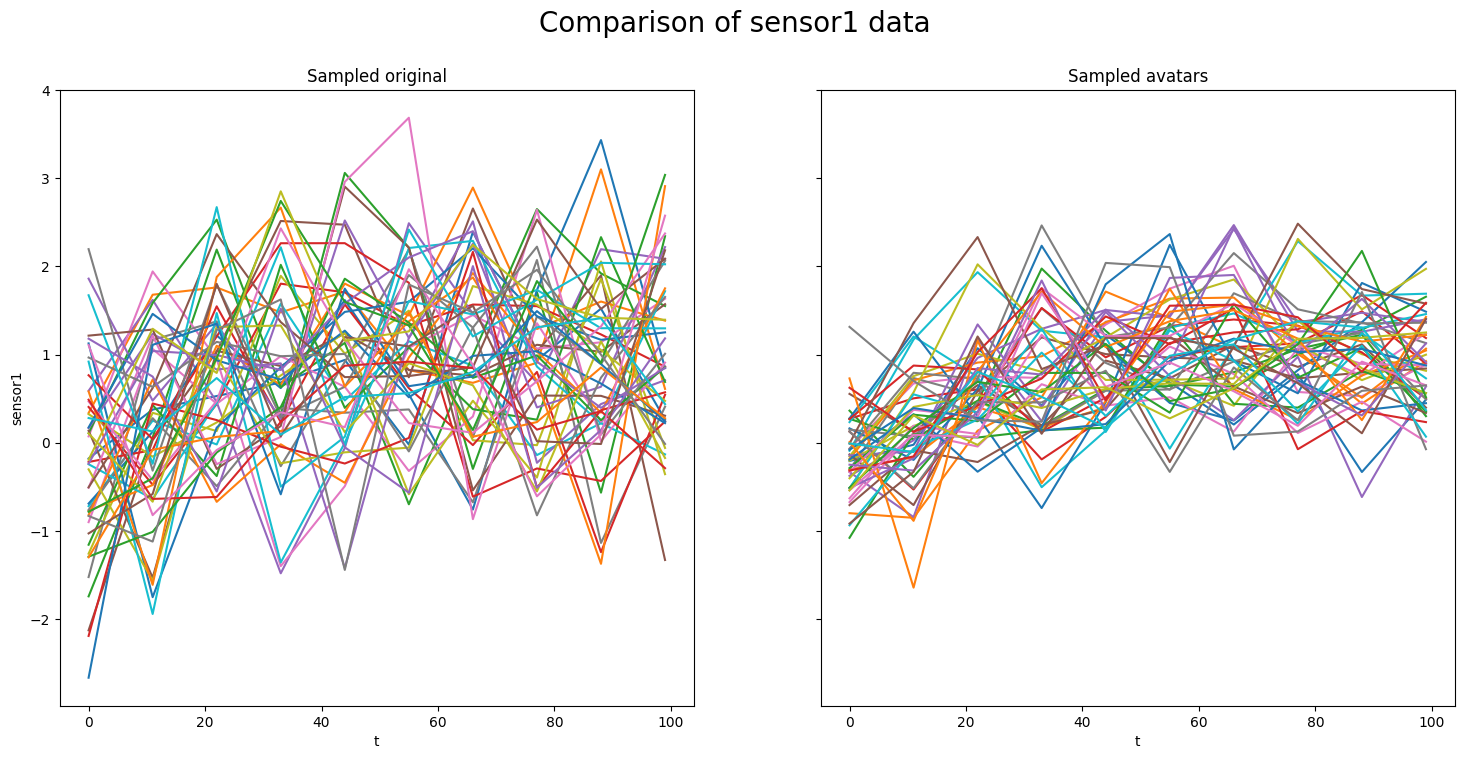

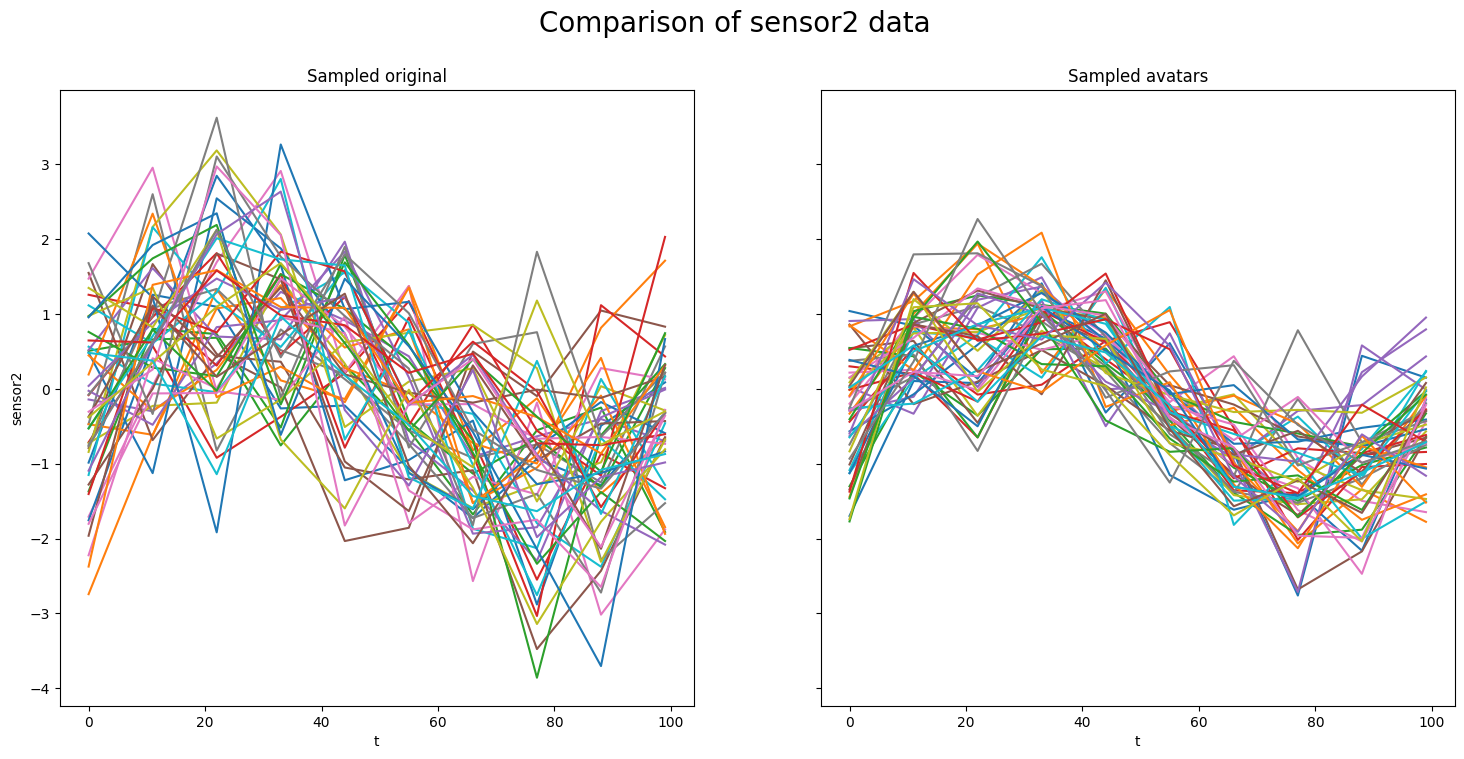

In [22]:
sampled_originals = timeseries_processor.postprocess(df, preprocessed_df)
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

for ax, df, suptitle in zip(
    axs,
    [sampled_originals, avatar_postprocessed_df],
    ["Sampled original", "Sampled avatars"],
):
    sns.lineplot(
        ax=ax,
        data=df,
        x="t",
        y="sensor1",
        hue="id",
        palette=sns.color_palette(),
        legend=False,
    )
    ax.set_title(suptitle)

fig.suptitle("Comparison of sensor1 data", fontsize=20)

fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

for ax, df, suptitle in zip(
    axs,
    [sampled_originals, avatar_postprocessed_df],
    ["Sampled original", "Sampled avatars"],
):
    sns.lineplot(
        ax=ax,
        data=df,
        x="t",
        y="sensor2",
        hue="id",
        palette=sns.color_palette(),
        legend=False,
    )
    ax.set_title(suptitle)
fig.suptitle("Comparison of sensor2 data", fontsize=20)